# Project of AIF on Road Sign Recognition (AI Part)

#### Made by :
- Tomas Szabo 
- Gaspard Langlais 
- Herald Nkounkou 

### Check if cuda is avaible for GPU acceleartion

In [7]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Use of :", device)

Use of : cuda


## Configuration

### Installation of YOLOv5

You need to download YOLOv5 first (and put it in the same place that this file) : https://github.com/ultralytics/yolov5/archive/refs/heads/master.zip

In [10]:
import os

# Unzip yolov5 archive
print("Unzipping yolov5-master.zip...")
os.system("unzip -o yolov5-master.zip")

# Rename folder for consistency
print("Renaming folder...")
os.system("rm -rf yolov5")  # remove existing folder if needed
os.system("mv yolov5-master yolov5")

# Install Python dependencies
print("Installing Python dependencies...")
os.system("pip install -r yolov5/requirements.txt")

print("YOLOv5 is ready.")

Checking for unzip...
unzip is already installed.
Unzipping yolov5-master.zip...
Archive:  yolov5-master.zip
fe1d4d9947735473006c68513168fef093ff17ce
   creating: yolov5-master/
  inflating: yolov5-master/.dockerignore  
  inflating: yolov5-master/.gitattributes  
   creating: yolov5-master/.github/
   creating: yolov5-master/.github/ISSUE_TEMPLATE/
  inflating: yolov5-master/.github/ISSUE_TEMPLATE/bug-report.yml  
  inflating: yolov5-master/.github/ISSUE_TEMPLATE/config.yml  
  inflating: yolov5-master/.github/ISSUE_TEMPLATE/feature-request.yml  
  inflating: yolov5-master/.github/ISSUE_TEMPLATE/question.yml  
  inflating: yolov5-master/.github/dependabot.yml  
   creating: yolov5-master/.github/workflows/
  inflating: yolov5-master/.github/workflows/ci-testing.yml  
  inflating: yolov5-master/.github/workflows/cla.yml  
  inflating: yolov5-master/.github/workflows/docker.yml  
  inflating: yolov5-master/.github/workflows/format.yml  
  inflating: yolov5-master/.github/workflows/links

### Preparation of the YAML

In [27]:
%cd yolov5

import os
from PIL import Image
import yaml

# === CONFIGURATION ===
label_file = "../GTSDB/gt.txt"             # Global annotation file (relative path)
image_input_dir = "../GTSDB/images_ppm"    # Directory with original .ppm images
base_dir = "../GTSDB"                      # Base GTSDB directory

# Target directories for YOLOv5 dataset structure
train_img_dir = os.path.join(base_dir, "train", "images")
train_lbl_dir = os.path.join(base_dir, "train", "labels")
test_img_dir = os.path.join(base_dir, "test", "images")
test_lbl_dir = os.path.join(base_dir, "test", "labels")

# Create directories if needed
for d in [train_img_dir, train_lbl_dir, test_img_dir, test_lbl_dir]:
    os.makedirs(d, exist_ok=True)

# === Load annotations from gt.txt ===
annotations = {}
class_ids = set()

with open(label_file, "r") as f:
    for line in f:
        parts = line.strip().split(";")
        if len(parts) != 6:
            continue
        img_name_ppm, xmin, ymin, xmax, ymax, cls = parts
        cls = int(cls)
        img_name_jpg = img_name_ppm.replace(".ppm", ".jpg")
        class_ids.add(cls)
        if img_name_jpg not in annotations:
            annotations[img_name_jpg] = []
        annotations[img_name_jpg].append((int(xmin), int(ymin), int(xmax), int(ymax), cls))

# === List and split all .ppm images ===
all_ppm_images = sorted([f for f in os.listdir(image_input_dir) if f.endswith(".ppm")])
total_images = len(all_ppm_images)
train_imgs = all_ppm_images[:600]
test_imgs = all_ppm_images[600:]

print(f"Total images found: {total_images}")
print(f"Images for training: {len(train_imgs)}")
print(f"Images for testing:  {len(test_imgs)}")

# === Convert image to .jpg and create corresponding YOLOv5 label ===
def process_image(img_name_ppm, target_img_dir, target_lbl_dir):
    img_path_ppm = os.path.join(image_input_dir, img_name_ppm)
    img_name_jpg = img_name_ppm.replace(".ppm", ".jpg")
    img_path_jpg = os.path.join(target_img_dir, img_name_jpg)

    if not os.path.exists(img_path_ppm):
        print(f"Image not found: {img_path_ppm}")
        return

    # Convert .ppm to .jpg
    with Image.open(img_path_ppm) as img:
        w, h = img.size
        img.convert("RGB").save(img_path_jpg, "JPEG")

    # Create YOLO label file
    label_txt_path = os.path.join(target_lbl_dir, img_name_jpg.replace(".jpg", ".txt"))
    with open(label_txt_path, "w") as out_f:
        if img_name_jpg in annotations:
            for xmin, ymin, xmax, ymax, cls in annotations[img_name_jpg]:
                x_center = ((xmin + xmax) / 2) / w
                y_center = ((ymin + ymax) / 2) / h
                box_w = (xmax - xmin) / w
                box_h = (ymax - ymin) / h
                out_f.write(f"{cls} {x_center:.6f} {y_center:.6f} {box_w:.6f} {box_h:.6f}\n")
        # If no annotations: file remains empty

# === Process all images ===
for img_name in train_imgs:
    process_image(img_name, train_img_dir, train_lbl_dir)

for img_name in test_imgs:
    process_image(img_name, test_img_dir, test_lbl_dir)

# === Generate YAML config for YOLOv5 ===
yaml_path = "gtsdb.yaml"  # relative to yolov5 directory
data_config = {
    "train": os.path.abspath(train_img_dir),
    "val": os.path.abspath(test_img_dir),
    "nc": max(class_ids) + 1,
    "names": [str(i) for i in range(max(class_ids)+1)]
}

with open(yaml_path, "w") as f:
    yaml.dump(data_config, f, default_flow_style=False)

print(f"\nDataset preparation complete.")
print(f"Training images saved in: {train_img_dir}")
print(f"Testing images saved in:  {test_img_dir}")
print(f"YAML file saved as: yolov5/{yaml_path}")
print(f"Detected class IDs: {sorted(class_ids)}")

[Errno 2] No such file or directory: 'yolov5'
/home/gasp/Work_Warsaw/Projet_IAF/yolov5
Total images found: 900
Images for training: 600
Images for testing:  300

Dataset preparation complete.
Training images saved in: ../GTSDB/train/images
Testing images saved in:  ../GTSDB/test/images
YAML file saved as: yolov5/gtsdb.yaml
Detected class IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]


### Verification of the dataset GTSDB (German Dataset)

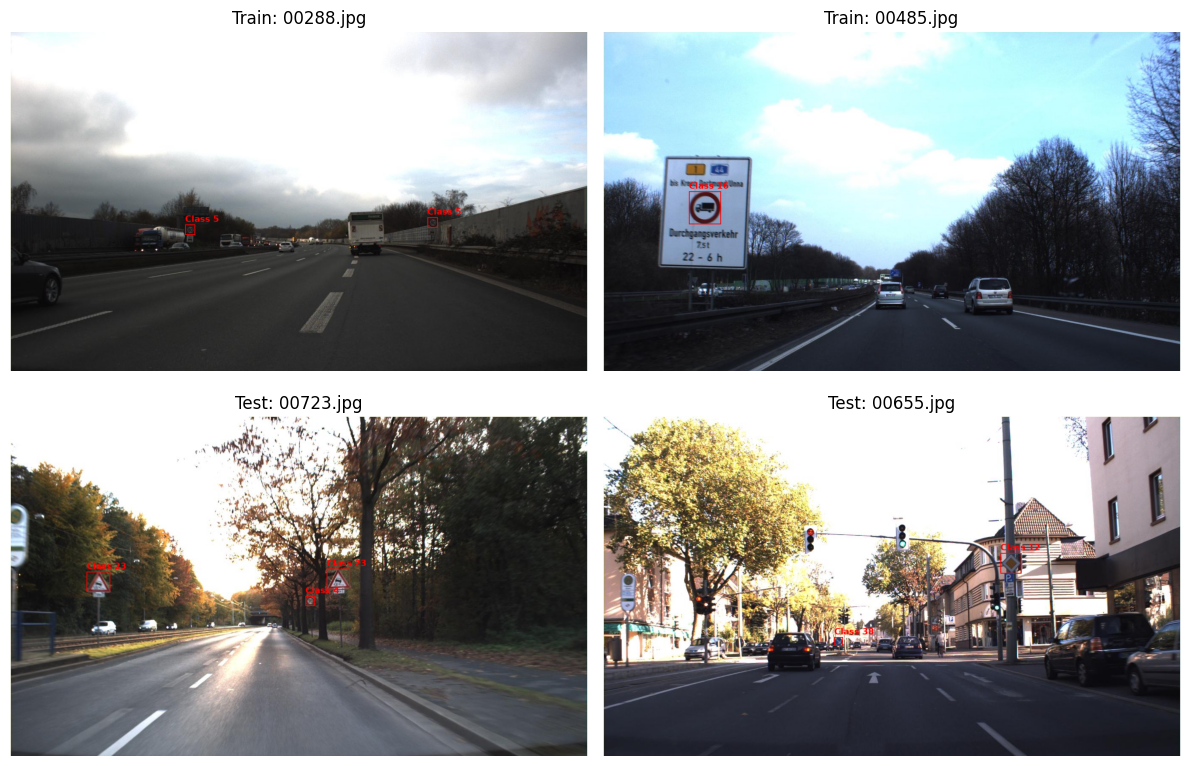

In [28]:
import os
import random
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# Paths (relative to yolov5/)
train_img_dir = "../GTSDB/train/images"
train_lbl_dir = "../GTSDB/train/labels"
test_img_dir = "../GTSDB/test/images"
test_lbl_dir = "../GTSDB/test/labels"

# Select 2 random .jpg images from train and 2 from test
train_images = random.sample([f for f in os.listdir(train_img_dir) if f.endswith(".jpg")], 2)
test_images = random.sample([f for f in os.listdir(test_img_dir) if f.endswith(".jpg")], 2)

# Build list of (image_dir, label_dir, filename)
samples = [(train_img_dir, train_lbl_dir, img) for img in train_images] + \
          [(test_img_dir, test_lbl_dir, img) for img in test_images]

def draw_yolo_labels(image_path, label_path):
    image = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(image)
    w, h = image.size

    # Try to load a large font
    try:
        import matplotlib
        font_path = os.path.join(matplotlib.get_data_path(), "fonts/ttf/DejaVuSans-Bold.ttf")
        font = ImageFont.truetype(font_path, size=20)
    except:
        font = ImageFont.load_default()

    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                if not line.strip():
                    continue
                parts = line.strip().split()
                cls = parts[0]
                xc, yc, bw, bh = map(float, parts[1:])
                xmin = int((xc - bw / 2) * w)
                xmax = int((xc + bw / 2) * w)
                ymin = int((yc - bh / 2) * h)
                ymax = int((yc + bh / 2) * h)

                draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=2)
                draw.text((xmin, max(ymin - 25, 0)), f"Class {cls}", fill="red", font=font)

    return image

# Display the 4 images
plt.figure(figsize=(12, 8))
for idx, (img_dir, lbl_dir, img_name) in enumerate(samples):
    img_path = os.path.join(img_dir, img_name)
    lbl_path = os.path.join(lbl_dir, img_name.replace(".jpg", ".txt"))
    image = draw_yolo_labels(img_path, lbl_path)

    plt.subplot(2, 2, idx + 1)
    plt.imshow(image)
    plt.title(f"{'Train' if idx < 2 else 'Test'}: {img_name}")
    plt.axis("off")

plt.tight_layout()
plt.show()

## Training

In [35]:
! python train.py \
  --img 1024 \
  --batch 16 \
  --epochs 30 \
  --data gtsdb.yaml \
  --weights yolov5s.pt \
  --name gtsdb_yolov5s

train: weights=yolov5s.pt, cfg=, data=gtsdb.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=30, batch_size=16, imgsz=1024, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=gtsdb_yolov5s, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 2025-4-18 Python-3.12.3 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentu

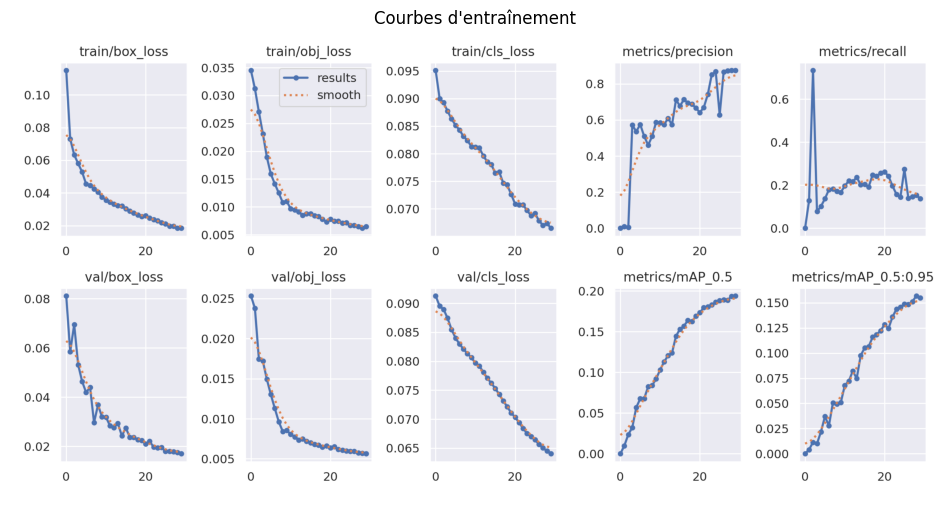

In [36]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("runs/train/gtsdb_yolov5s6/results.png")
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis("off")
plt.title("Courbes d'entraînement")
plt.show()

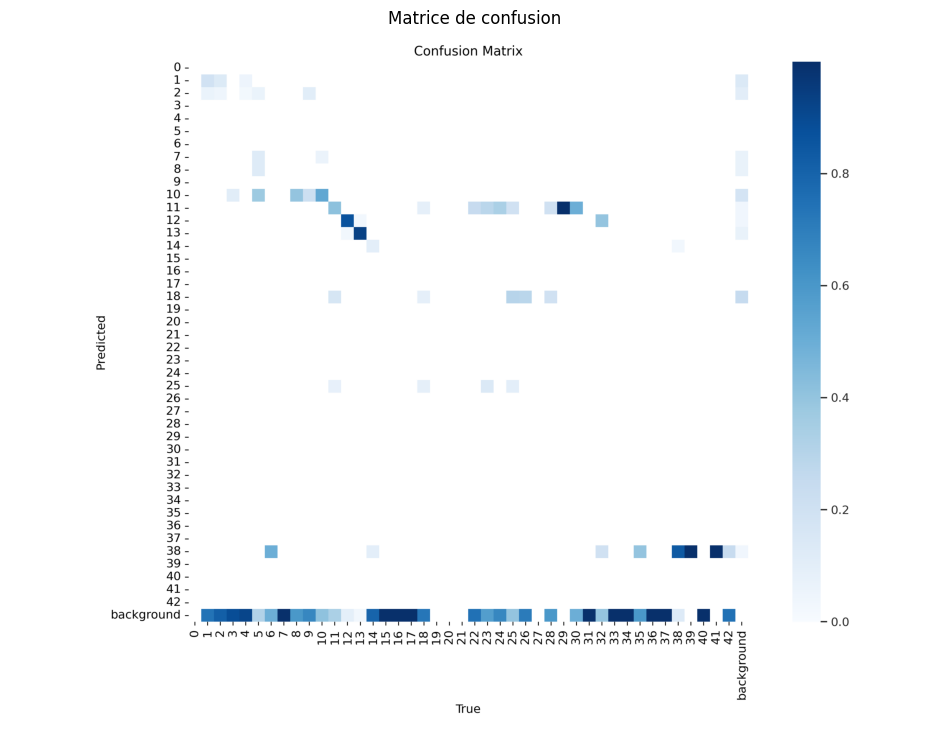

In [37]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("runs/train/gtsdb_yolov5s5/confusion_matrix.png")
plt.figure(figsize=(12, 10))
plt.imshow(img)
plt.axis("off")
plt.title("Matrice de confusion")
plt.show()

## Testing

In [73]:
!python detect.py \
  --weights runs/train/gtsdb_yolov5s6/weights/best.pt \
  --img 640 \
  --conf 0.15 \
  --source ../image_test.jpg \
  --name test_output

detect: weights=['runs/train/gtsdb_yolov5s6/weights/best.pt'], source=../image_test.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.15, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=test_output, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 2025-4-18 Python-3.12.3 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)

Fusing layers... 
Model summary: 157 layers, 7126096 parameters, 0 gradients, 16.1 GFLOPs
image 1/1 /home/gasp/Work_Warsaw/Projet_IAF/image_test.jpg: 448x640 2 25s, 28.3ms
Speed: 0.7ms pre-process, 28.3ms inference, 114.8ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/test_output19


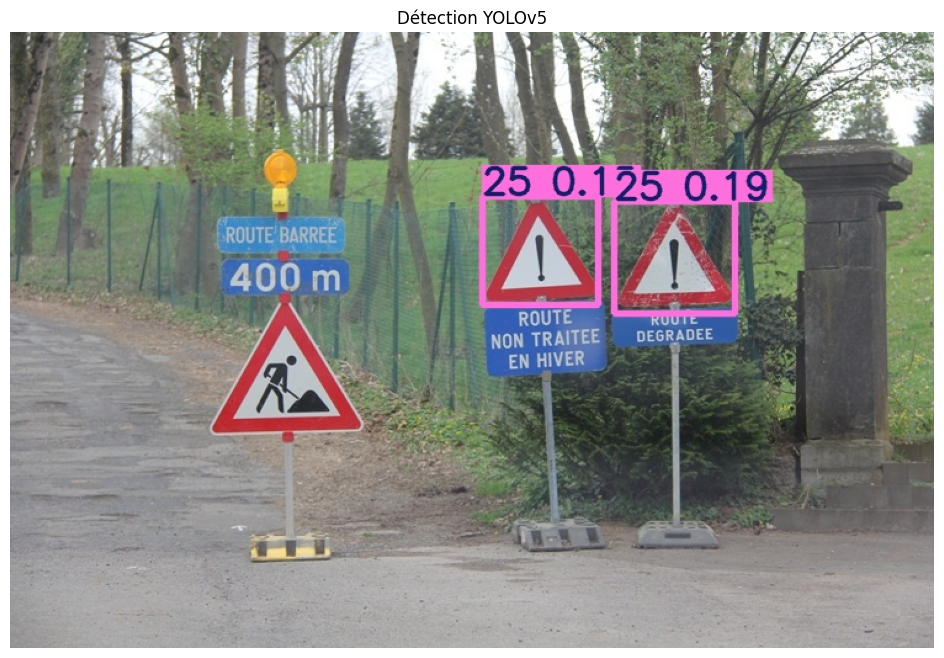

In [74]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("runs/detect/test_output19/image_test.jpg")
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis("off")
plt.title("Détection YOLOv5")
plt.show()